# Viga de Euler-Bernoulli

Exemplo baseado na documentação e em livros de Mecânica do Sólidos  
**Notebook por:** Paulo de Souza Silva  
**Data:** Maio/Junho de 2025

**IGNORE ESTE CÓDIGO INICIAL**

* Se a figura da viga não aparecer, basta rodá-lo.

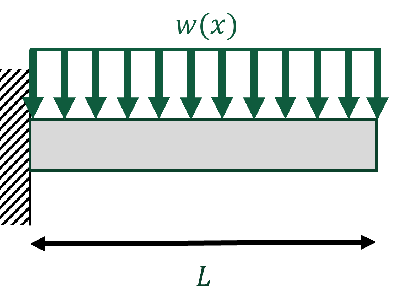

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1QIS7MK41m-Dd-d6rZ8mM0iP96omcy17w'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (400, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)

**instalacoes**

O SciANN não funciona com as versões atuais do TensorFlow e do Keras, portanto é necessário:
1. Desinstalar as duas bibliotecas (keras e tensorflow)
2. Reinstalar com uma versão anterior compatível (por exemplo a 2.12)
3. Instalar o SciANN

**rodar o bloco a seguir duas vezes**
1. Normalmente ocorre um pequeno erro e é necessário reiniciar o ambiente
2. Após reiniciar o ambiente, rode novamente esse bloco e as instalações serão completadas

In [1]:
! pip uninstall -y keras tensorflow
! pip install tensorflow==2.12
! pip install sciann

Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-text 2.18.1 requires tenso

**bibliotecas principais**

Note que além das bibliotecas tradicionais, iremos chamar funções matemáticas pertencentes ao SciANN e que serão **úteis** para o problema.

`diff` usada para calcular as equações diferenciais  
`sign` usado para calcular a suavização da condição de contorno  
`exp` usado para calcular a suavização da condição de contorno


In [2]:
import numpy as np
import sciann as sn
from sciann.utils.math import diff, sign, exp
import matplotlib.pyplot as plt

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0] 



## Obtenção da Solução Analítica

Ao contrário da solução feita no notebook do DeepXDE aqui vamos partir da equação diferencial de segunda ordem, relacionada ao Momento Fletor $M(x)$, logo a expressão da viga pode ser escrita como:

$$EI\frac{d^2y}{dx^2} = M(x)$$

Das considerações do **momento fletor**, temos que **nessa configuração da Figura**:
$$M(x) = -w \frac{(L-x)^2}{2}$$

Com isso em mente devemos aplicar a integral somente duas vezes e depois considerar as condições.



## Integrações
Vamos expandir a função do momento fletor:
$$M(x) = -\frac{w}{2} (L^2 - 2xL + x^2)$$

### 1º Integração

$$EIy' = -\frac{w}{2} \left(L^2x - x^2L + \frac{x^3}{3}\right) + C_1$$

### 2º Integração
$$EIy = -\frac{w}{2} \left(\frac{L^2x^2}{2} - \frac{x^3}{3}L + \frac{x^4}{12}\right) + C_1 x + C_2$$

No engaste $x=0$ o deslocamento e a rotação são nulos e portanto, $C_1 = C_2 = 0$

Fazendo as devidadas manipulações chegamos na mesma solução do notebook do DeepXDE:
$$y = \frac{-w}{EI}\left(\frac{x^4}{24} - \frac{Lx^3}{6}+\frac{L^2x^2}{4}\right)$$


**parâmetros do problema**

In [3]:
w = 1
L = 1
EI = 1

**definições iniciais**  
No SciANN podemos criar de forma mais direta a nossa estrutura da rede, para isso, definimos:  
* **`sn.Variable`** quem será nossa variável de entrada;
* **actv** definindo a função de ativação (vamos usar a `tahn`)
* **`sn.Functional`** usado para definir quem será a saída da rede, passando as entradas, formato e função de ativação

É possível ainda já definir as equações referentes ao problema a ser resolvido



In [4]:
x = sn.Variable('x')
actv = 'tanh'
y = sn.Functional('y', [x], 3*[20], activation=actv)

Mx = - w * ((L-x)**2) / 2
pde = EI*diff(y, x, order=2) - Mx

### **condições de contorno**

No SciANN temos que impor as condições de contorno (BCs) utilizando **estratégias de suavização**, que farão com que a BCs sejam consideradas somente nos pontos ou regiões desejadas.

A estratégia de suavização é, apesar de considerar funções, considerada uma **condição fraca**, pois **não estamos** alterando o resultado da rede inteira.


**TIPOS DE SUAVIZAÇÃO**

*Suavizado por Sinal*
>   A função sinal é definida como
$$sign(x) = \begin{cases}
1 & \text{se} \ x > 0 \\
0 & \text{se} \ x = 0 \\
-1 & \text{se} \ x < 0
\end{cases}$$  
O que queremos é que quando $x = 0$ aconteça com que $y(0) = 0$ e $y'(0)=0$ e em qualquer outro ponto isso não aconteça. Nosso domínio é definido no intervalo entre 0 e 1, portanto $x\geq0$.  
Assim, as condições de contorno com a utilização da função sinal e considerando uma pequena tolerância ($\approx 0$) tem as formas:  
* $bc_1: (1 - sign(x - tol)) \cdot y $
* $bc_2: (1 - sign(x - tol)) \cdot y' $  


*Suavizado por Exponencial*  
> A estratégia é usar a função exponencial com um coeficiente negativo $k$ elevado, multiplicando uma função relacionada ao ponto que é o contorno.  
Se assumirmos $k = 10000$ podemos atribuir a função $x$ e temos os seguintes formatos para nossas condições:  
* $bc_1: e^{-kx} \cdot y $
* $bc_2: e^{-kx} \cdot y'$

In [5]:
## Suavizado com função sinal
# TOL = 1E-5
# bc1 = (1 - sign(x - TOL)) * y
# bc2 = (1 - sign(x - TOL)) * diff(y,x)

## suavizado com exponencial
k = 10000  # Fator de suavização
bc1 = exp(-k * x) * y            # u(0) = 0
bc2 = exp(-k * x) * diff(y, x)   # u'(0) = 0


**definição do modelo**  
Agora definimos o nosso modelo com o comando **`sn.SciModel`** neste comando é necessário definir:  
* **`inputs`** passar a variável de entrada
* **`targets`** os alvos (targets) são nossa equação diferencial e funções relacionadas a condição inicial, contorno ou qualquer outra que contribua para o formalismo
* **`loss_func`** definimos a função de perda (adotaremos o MSE)
* **`optimizer`** definimos o otimizador (adotaremos o ADAM)

In [6]:
# Modelo
model = sn.SciModel(
    inputs=[x],
    targets=[pde, bc1, bc2],
    loss_func="mse",
    optimizer='adam'
)


**definição do modelo de treinamento**

`x_treino` Devemos definir um vetor (ou matriz) que servirá para o treinamento  

Na sequência é definido o treinamento, ele segue uma estrutura que recebe:
* Dados de treino
* Valor que as funções do **targets** devem ter
* Outros parâmetros essenciais para rede: **epócas, tamanho do batch, taxa de aprendizado** etc.

In [ ]:
x_treino = np.linspace(0, 1, 100).reshape(-1, 1)

historia = model.train(x_treino,
                       ['zeros','zeros','zeros'],
                       epochs = 500,
                       batch_size = 32,
                       learning_rate=0.001,
                       verbose = 1)



Total samples: 100 
Batch size: 32 
Total batches: 4 

Epoch 1/500
4/4 [==============================] - 0s 3ms/step - batch: 1.5000 - size: 25.0000 - loss: 1.1939e-05 - sub_loss: 1.1299e-05 - mul_4_loss: 3.5755e-09 - mul_6_loss: 2.9503e-07 - lr: 0.0010 - time: 0.0179
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - batch: 1.5000 - size: 25.0000 - loss: 1.5723e-05 - sub_loss: 1.5991e-05 - mul_4_loss: 1.3834e-09 - mul_6_loss: 8.1767e-09 - lr: 0.0010 - time: 0.0941
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - batch: 1.5000 - size: 25.0000 - loss: 1.6689e-05 - sub_loss: 1.5488e-05 - mul_4_loss: 1.4405e-09 - mul_6_loss: 3.7049e-07 - lr: 0.0010 - time: 0.0974
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - batch: 1.5000 - size: 25.0000 - loss: 1.6783e-05 - sub_loss: 1.5968e-05 - mul_4_loss: 2.8649e-10 - mul_6_loss: 3.5811e-07 - lr: 0.0010 - time: 0.1030
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - batch: 1.5000 - siz

In [8]:
def func(x):
    return (-w/EI)*((x**4)/24 - ((L*x**3)/6) + (L**2 * x**2 / 4))

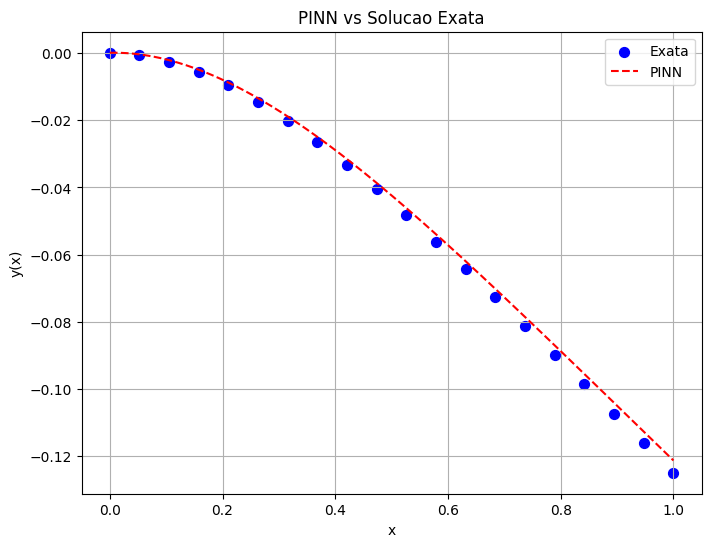

In [9]:
# Calculo da solucao predita
x_pinn = np.linspace(0, 1, 200).reshape(-1, 1)
y_pinn = y.eval(model,x_pinn)

# Calculo da solucao exata
x_values_exato = np.linspace(0,1,20).reshape(-1,1)
y_exato = func(x_values_exato)

plt.figure(figsize=(8, 6))
plt.scatter(x_values_exato, y_exato, label = 'Exata', color = 'blue', marker = "o", s = 50)
plt.plot(x_pinn,y_pinn,label='PINN', color = "red", linestyle = "--")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("PINN vs Solucao Exata")
plt.legend()
plt.grid()
plt.show()

In [11]:
loss_pde = historia.history['sub_loss']
loss_bcs = np.array(historia.history['mul_4_loss']) + np.array(historia.history['mul_6_loss'])
loss_total = historia.history['loss']

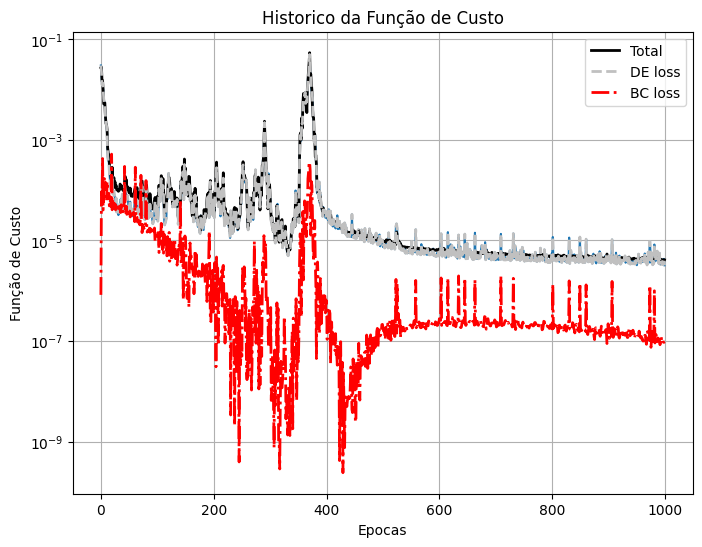

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.semilogy(historia.history['sub_loss'])
plt.plot(loss_total, 'k', linewidth=2, label="Total")
plt.plot(loss_pde, color='silver', linestyle='--', linewidth=2, label="DE loss")
plt.plot(loss_bcs, color='r', linestyle='-.', linewidth=2, label="BC loss")

plt.xlabel('Epocas')
plt.ylabel('Função de Custo')
plt.yscale('log')
plt.title('Historico da Função de Custo')
plt.legend()
plt.grid(True)
plt.show()